In [1]:
import os
import tensorflow as tf
from tensorflow.core.util import event_pb2
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

figsize=(15, 10)
export_dir = './plots/'
data_dir = '/home/yuxin/ray_results/PPO/PPO_meltingpot_'
env_list = ['Pure_Coordination_S_5M','Pure_Coordination_M_5M','Pure_Coordination_L_5M','Pure_Coordination_O_5M']
total_timestep = 6e6

sns.set()
sns.set_context("talk")

2023-07-14 22:32:45.215235: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-14 22:32:45.944042: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/yuxin/.conda/envs/meltingpot/lib/:/home/yuxin/.conda/envs/meltingpot/lib/python3.9/site-packages/nvidia/cudnn/lib
2023-07-14 22:32:45.944124: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :

In [2]:
def get_section_results(file, env_name, *tags):
    data_dict = {'env_step': [], 'env_name': []}
    data_dict.update({tag: [] for tag in tags})
    max_step = -1
    for e in tf.compat.v1.train.summary_iterator(file):
        prev_step = -1
        for v in e.summary.value:
            if v.tag in data_dict:
                data_dict[v.tag].append(v.simple_value)
                if prev_step != e.step:
                    prev_step = e.step
                    if max_step < e.step:
                        max_step = e.step
                        data_dict['env_step'].append(e.step)
                        data_dict['env_name'].append(env_name)
    data_dict = {tag: np.array(data_dict[tag]) for tag in data_dict}
    return data_dict

In [3]:
def read_evaluation_data(env_list, size, smooth_alpha):
    full_data = pd.DataFrame()
    plot_data = pd.DataFrame()

    for env in env_list:
        logdir = os.path.join(data_dir+env, 'events*')
        print(logdir)
        eventfile = glob.glob(logdir)[0]
        data_dict = get_section_results(eventfile, env, 'ray/tune/episode_reward_min',
                                        'ray/tune/episode_reward_mean','ray/tune/episode_reward_max')
        data = pd.DataFrame(data_dict)
        for (columnName, columnData) in data.items():
            if columnName != 'env_step' and columnName != 'env_name':
                data[f'{columnName}_smooth'] = data[columnName].ewm(alpha=smooth_alpha).mean()

        # reduce size for plotting
        count_row = data.shape[0]
        reduced_row = np.linspace(0, count_row-1, size, dtype=int, endpoint=True)
        data_p = data.iloc[reduced_row]

        full_data = pd.concat([full_data, data], axis=0)
        plot_data = pd.concat([plot_data, data_p], axis=0)
    return full_data, plot_data

In [4]:
data, data_plot = read_evaluation_data(env_list, 500, 0.2)

/home/yuxin/ray_results/PPO/PPO_meltingpot_Pure_Coordination_S_5M/events*
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
/home/yuxin/ray_results/PPO/PPO_meltingpot_Pure_Coordination_M_5M/events*
/home/yuxin/ray_results/PPO/PPO_meltingpot_Pure_Coordination_L_5M/events*
/home/yuxin/ray_results/PPO/PPO_meltingpot_Pure_Coordination_O_5M/events*


In [5]:
data_plot

,env_step,env_name,ray/tune/episode_reward_min,ray/tune/episode_reward_mean,ray/tune/episode_reward_max,ray/tune/episode_reward_min_smooth,ray/tune/episode_reward_mean_smooth,ray/tune/episode_reward_max_smooth
0,3200,Pure_Coordination_S_5M,7.985238,7.985238,7.985238,7.985238,7.985238,7.985238
6,12800,Pure_Coordination_S_5M,7.985238,17.638416,38.262302,7.985238,15.826444,29.822351
12,22400,Pure_Coordination_S_5M,7.985238,17.922354,38.262302,7.985238,17.913340,36.412095
18,32000,Pure_Coordination_S_5M,7.985238,18.323763,38.262302,7.985238,18.156928,37.797244
25,43200,Pure_Coordination_S_5M,7.985238,19.631979,54.381180,7.985238,19.654715,50.943007
...,...,...,...,...,...,...,...,...
3097,4958400,Pure_Coordination_O_5M,23.936508,46.692081,119.891273,23.942653,46.427926,119.783520
3104,4969600,Pure_Coordination_O_5M,23.936508,47.184120,119.891273,23.937797,46.806669,119.868676
3110,4979200,Pure_Coordination_O_5M,23.936508,47.551357,119.891273,23.936846,47.282537,119.885350
3116,4988800,Pure_Coordination_O_5M,23.936508,47.680984,119.891273,23.936597,47.685686,119.889721


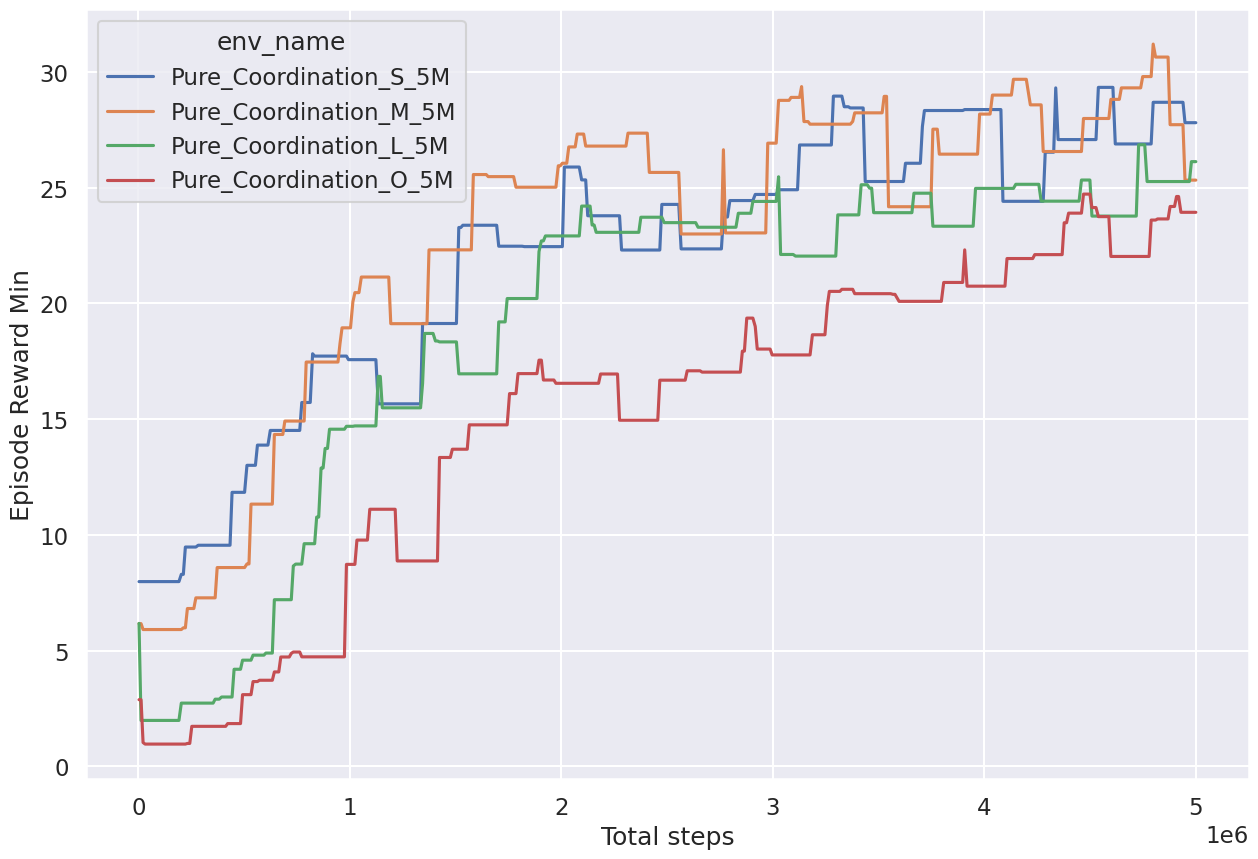

In [6]:
fig, ax = plt.subplots(figsize=figsize)
g = sns.lineplot(data=data_plot, x='env_step', y='ray/tune/episode_reward_min', hue='env_name')
ax.set(xlabel='Total steps', ylabel='Episode Reward Min')
# plt.xticks(np.arange(0, total_timestep, 5e5))
# xlabels = ['{:.1f}'.format(x) + 'M' for x in g.get_xticks()/1e6]
# g.set_xticklabels(xlabels)
plt.savefig(os.path.join(export_dir, 'pure_coordinatin_ep_reward_min.pdf'), bbox_inches='tight')

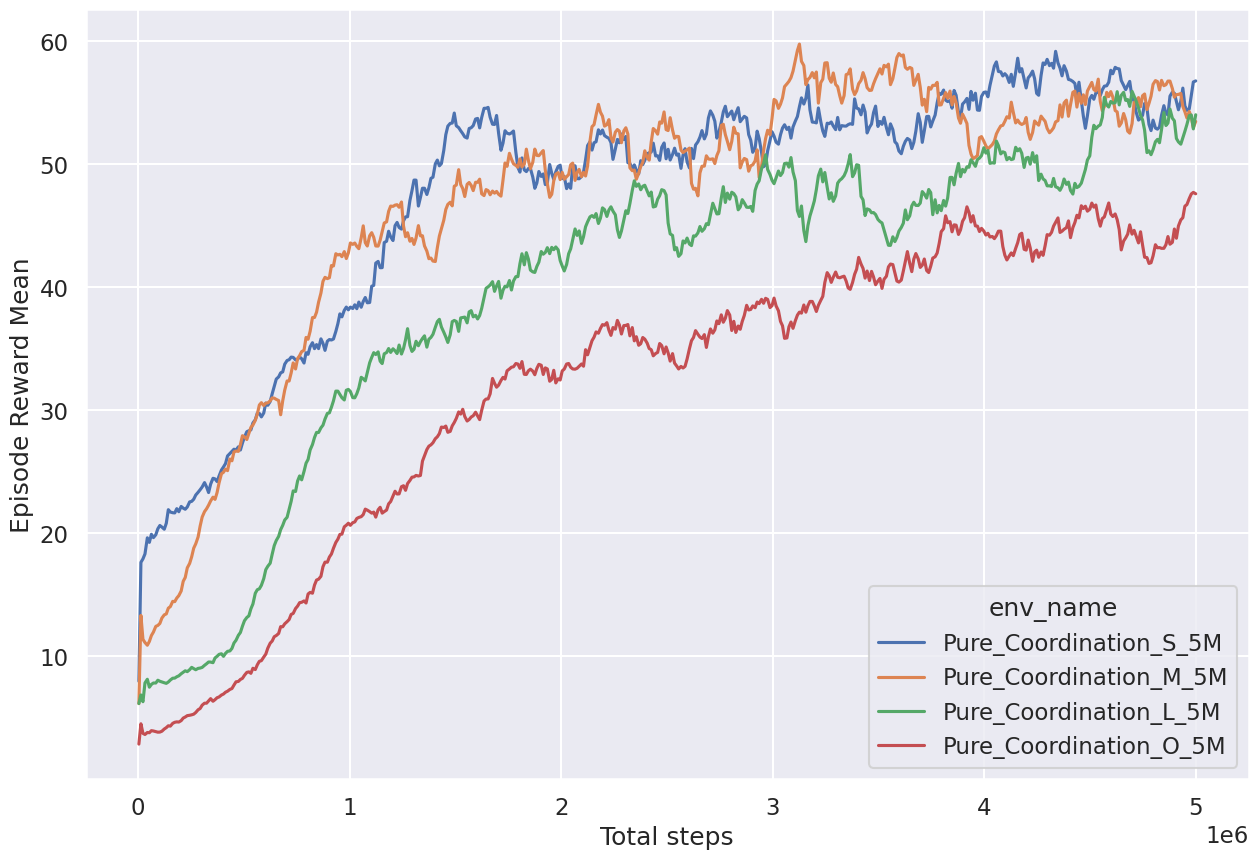

In [7]:
fig, ax = plt.subplots(figsize=figsize)
g = sns.lineplot(data=data_plot, x='env_step', y='ray/tune/episode_reward_mean', hue='env_name')
ax.set(xlabel='Total steps', ylabel='Episode Reward Mean')
# plt.xticks(np.arange(0, total_timestep, 5e5))
# xlabels = ['{:.1f}'.format(x) + 'M' for x in g.get_xticks()/1e6]
# g.set_xticklabels(xlabels)
plt.savefig(os.path.join(export_dir, 'pure_coordinatin_ep_reward_mean.pdf'), bbox_inches='tight')

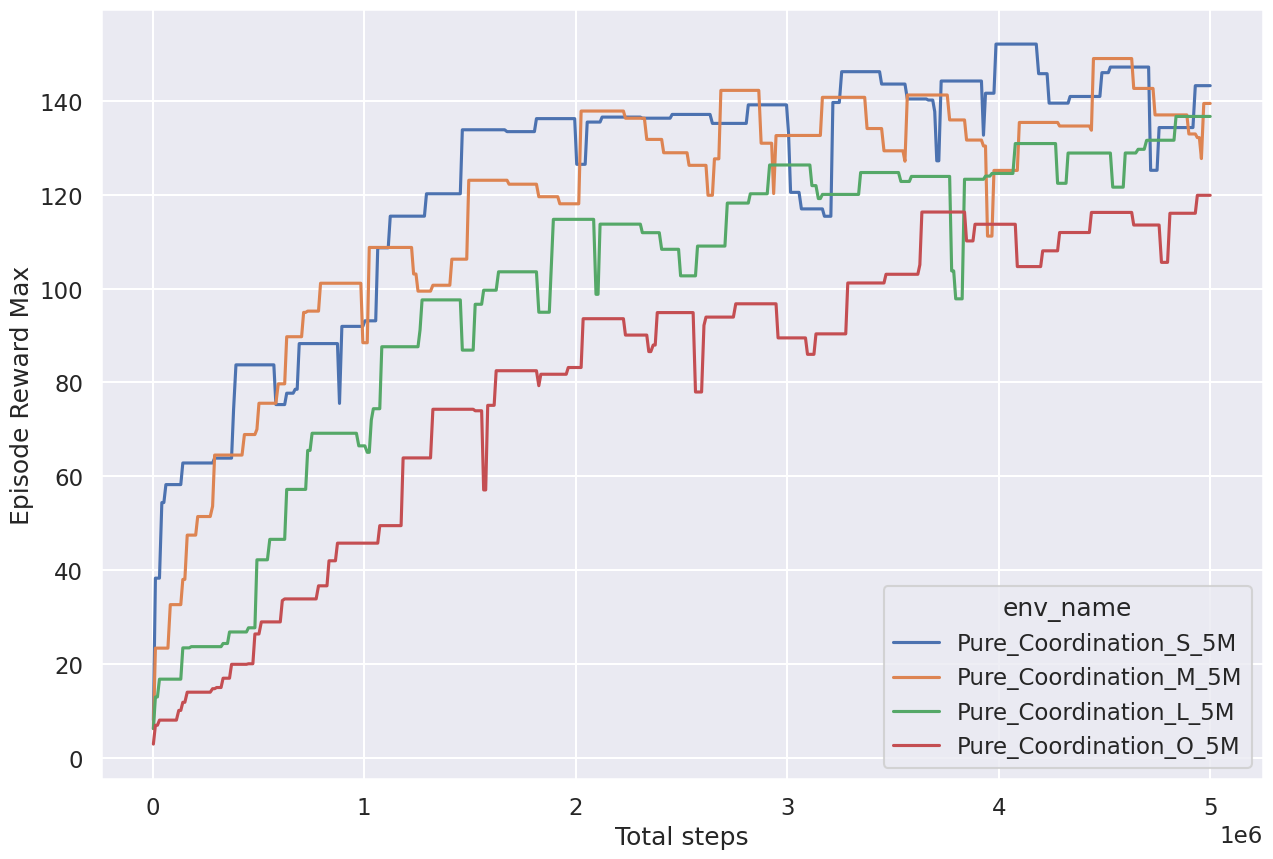

In [8]:
fig, ax = plt.subplots(figsize=figsize)
g = sns.lineplot(data=data_plot, x='env_step', y='ray/tune/episode_reward_max', hue='env_name')
ax.set(xlabel='Total steps', ylabel='Episode Reward Max')
# plt.xticks(np.arange(0, total_timestep, 5e5))
# xlabels = ['{:.1f}'.format(x) + 'M' for x in g.get_xticks()/1e6]
# g.set_xticklabels(xlabels)
plt.savefig(os.path.join(export_dir, 'pure_coordinatin_ep_reward_max.pdf'), bbox_inches='tight')